In [1]:
import os

from matplotlib import pyplot as plt
import seaborn as sns

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones,
                          load_paralog_pairs)
from plotting import y2h_ppi_per_paralog_pair_plot

%matplotlib inline

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()

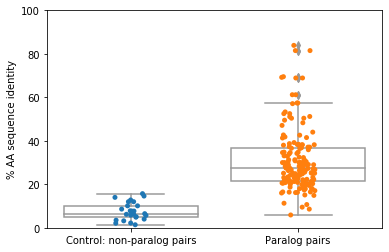

In [6]:
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity')
sns.boxplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity', color='white')
ax.set_ylim(0, 100)
ax.set_ylabel('% AA sequence identity')
ax.set_xticklabels(['Control: non-paralog pairs', 'Paralog pairs'])
ax.set_xlabel('')
plt.savefig('../../figures/paralog_nonparalog_aa_identity.pdf',
            bbox_inches='tight')

In [8]:
for i, row in pairs.iterrows():
    fig, ax = plt.subplots(1, 1)
    a = row['tf_gene_a']
    b = row['tf_gene_b']
    y2h_ppi_per_paralog_pair_plot(a, b, y2h, ax=ax)
    os.makedirs('../../figures/paralog_pairs', exist_ok=True)
    plt.savefig('../../figures/paralog_pairs/' + a + '_' + b + '.pdf',
                bbox_inches='tight')
    plt.close(fig)

In [39]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 914 tested partners, 728 had at least one positive result


In [40]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))
# remove these interactions where none of the isoforms are positive
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0


In [41]:
print('Total TF genes with cloned isoforms: {}'.format(isoforms['gene'].nunique()))
print('Total TF genes with 2+ cloned isoforms: {}'.format(sum((isoforms.groupby('gene').count()>1)['clone_acc'])))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_gene_symbol'].nunique()))
print('with ≥ 2 isoforms with ≥ 1 PPI each: {}'
       .format(
          (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   (y2h['score'] == '1'), 
                   :]
              .groupby('ad_gene_symbol')
              ['ad_clone_acc']
              .nunique()
              >= 2).sum()  
         )
     )
print('with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: {}'
       .format(
        (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   y2h['score'].isin(['0', '1']), 
                   :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['ad_clone_acc']
              .nunique() # number of isoforms per partner with valid interactions
              >= 2)
              .reset_index()
              .groupby('ad_gene_symbol').sum() >= 2).sum().iat[0])
     )
)

Total TF genes with cloned isoforms: 312
Total TF genes with 2+ cloned isoforms: 254
with ≥ 1 PPI: 132
with ≥ 2 isoforms with ≥ 1 PPI each: 72
with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: 90


In [42]:
print('Total TF isoforms: {}'.format(isoforms['clone_acc'].nunique()))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_clone_acc'].nunique()))

Total TF isoforms: 792
with ≥ 1 PPI: 242


In [43]:
from ccsblib import huri

hiu = huri.load_nw_hi_union(id_type='ensembl_gene_id')
lit = huri.load_nw_lit_17(id_type='ensembl_gene_id')
litb = lit.loc[lit['category'].isin(['Lit-BM', 'Lit-BS']), :].copy()
litbm = lit.loc[lit['category'].isin(['Lit-BM']), :].copy()

def map_gene_names(nw):
    return set(huri.map_nw_ids(nw, 'ensembl_gene_id', 'hgnc_symbol').index)

hiu = map_gene_names(hiu)
lit = map_gene_names(lit)
litbm = map_gene_names(litbm)
litb = map_gene_names(litb)

Creating directory /Users/gloriasheynkman/Library/Application Support/bioservices 
Creating directory /Users/gloriasheynkman/Library/Caches/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /Users/gloriasheynkman/Library/Application Support/bioservices/bioservices.cfg .
Done


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gloriasheynkman/Library/ccsblib/data/external/ensembl_aug2017_hgnc_id_map.csv'

In [ ]:
new_ppis = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'),
                        ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
new_ppis = set((new_ppis[['ad_gene_symbol', 'db_gene_symbol']].min(axis=1) + '_' +
               new_ppis[['ad_gene_symbol', 'db_gene_symbol']].max(axis=1)).drop_duplicates().values)

In [7]:
print('Total number of PPIs at isoform-level: {}'
        .format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'), ].shape[0]))
print('Gene-gene PPIs: {}'.format(len(new_ppis)))
print('Not in HI-Union: {}'.format(len(new_ppis.difference(hiu))))
print('Not in HI-Union or Lit-BM: {}'.format(len(new_ppis.difference(hiu.union(litbm)))))
print('Not in HI-Union or Lit-B: {}'.format(len(new_ppis.difference(hiu.union(litb)))))
print('Not in HI-Union or Lit-NB: {}'.format(len(new_ppis.difference(hiu.union(lit)))))

Total number of PPIs at isoform-level: 2450
Gene-gene PPIs: 1371
Not in HI-Union: 565
Not in HI-Union or Lit-BM: 555
Not in HI-Union or Lit-B: 553
Not in HI-Union or Lit-NB: 523


### TODO

Can we quantify how many additional PPIs we get from studying multiple isoforms relative a single isoform?

We would want to use the screening data, filtered by the pairwise test data, I guess.

Would need to distinguish beetween screening with the same clone twice vs two different isoforms?

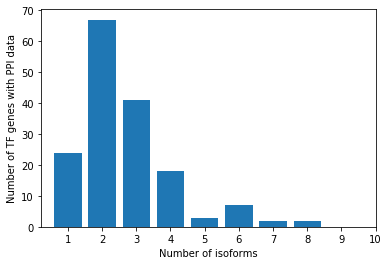

In [10]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data');

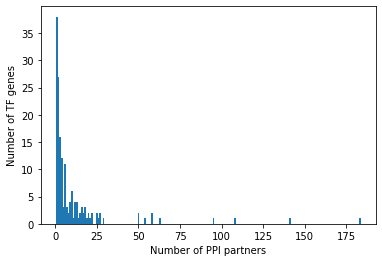

In [11]:
n_ppi = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes');

## TODO

Plot degree of binding partners vs. fraction of isoforms interacting